# Example Notebook for the SimplePybsmGenerator Implementation

This example notebook demonstrates how to use the `SimplePysbmGenerator` class to generate item-response curves (IRC) for a given input image, perturber, and scorer metric.

## Table of Contents
* [Set Up the Environment](#environment-setup)
* [Select Sample Input Image and Detections](#sample-input-image-and-detection)
* [Select Sample Input Sensor and Scenario](#sample-sensor-and-scenario)
* [Initialize Pipeline Instances](#initialize-pipeline-instances)
* [Generate and Visualize Item-Response Curves](#generate-and-visualize-item-response-curves)

To run this notebook in Colab, use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kitware/nrtk/blob/main/docs/examples/simple_pybsm_generator.ipynb)

## Set Up the Environment <a name="environment-setup"></a>

**Note for Colab users**: After setting up the environment, you may need to "Restart Runtime" in order to resolve package version conflicts (see the [README](https://github.com/Kitware/nrtk/blob/main/docs/examples/README.md#run-the-notebooks-from-colab) for more info).

Note: We are suppressing warnings within this notebook to reduce visual clutter for demonstration purposes. If any issues arise while executing this notebook, we recommend that this cell is **not** executed so that any related warnings are shown. 

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import sys  # noqa: F401

!{sys.executable} -m pip install -qU pip
print("Installing nrtk...")
# !{sys.executable} -m pip install -q "nrtk[pybsm]"
print("Installing torch and torchvision...")
# !{sys.executable} -m pip install -q "torch!=2.0.1" torchvision
print("Installing headless OpenCV...")
# !{sys.executable} -m pip uninstall -qy opencv-python opencv-python-headless  # make sure they're both gone.
# !{sys.executable} -m pip install -q opencv-python-headless
print("Done!")

Installing nrtk...
Installing torch and torchvision...
Installing headless OpenCV...
Done!


## Select Sample Input Image and Detections <a name="sample-input-image-and-detection"></a>

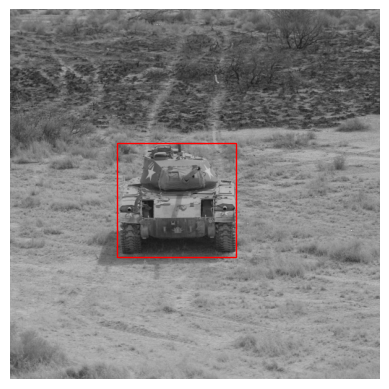

In [3]:
import os
import urllib.request

import cv2
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from smqtk_image_io.bbox import AxisAlignedBoundingBox

data_dir = "./pybsm/data"
os.makedirs(data_dir, exist_ok=True)

url = "https://data.kitware.com/api/v1/item/6596fde89c30d6f4e17c9efc/download"

img_path = os.path.join(data_dir, "M-41 Walker Bulldog (USA) width 319cm height 272cm.tiff")
if not os.path.isfile(img_path):
    _ = urllib.request.urlretrieve(url, img_path)  # noqa: S310

img = cv2.imread(img_path)

gt = [(AxisAlignedBoundingBox([148, 185], [148 + 165, 185 + 158]), {"category": "tank"})]
img_gsd = 3.19 / 165.0  # the width of the tank is 319 cm and it spans ~165 pixels in the image

bbox = gt[0][0]
width = bbox.max_vertex[0] - bbox.min_vertex[0]
height = bbox.max_vertex[1] - bbox.min_vertex[1]

fig, ax = plt.subplots()
ax.imshow(img)
ax.set_axis_off()
ax.add_patch(
    Rectangle(
        (bbox.min_vertex[0], bbox.min_vertex[1]),
        width,
        height,
        linewidth=1,
        edgecolor="r",
        facecolor="none",
    ),
)
plt.show()

## Select Sample Input Sensor and Scenario <a name="sample-sensor-and-scenario"></a>

We've preselected parameters for brevity. For insight into what goes into selecting these parameters, see the [pyBSM explanation](https://pybsm.readthedocs.io/en/latest/explanation.html) for image formation concepts and OTFs.

In [4]:
from pybsm.otf import dark_current_from_density

# telescope focal length (m)
f = 4
# Telescope diameter (m)
D = 275e-3

# detector pitch (m)
p = 0.008e-3

# Optical system transmission, red  band first (m)
opt_trans_wavelengths = np.array([0.58 - 0.08, 0.58 + 0.08]) * 1.0e-6

L3 = {
    # required
    "sensor_name": "L32511x",
    "D": D,  # Telescope diameter (m)
    "f": f,  # telescope focal length (m)
    "p_x": p,  # detector pitch (m)
    "opt_trans_wavelengths": opt_trans_wavelengths,  # Optical system transmission, red  band first (m)
    # optional
    "optics_transmission": 0.5
    * np.ones(opt_trans_wavelengths.shape[0]),  # guess at the full system optical transmission
    # (excluding obscuration)
    "eta": 0.4,  # guess
    "w_x": p,  # detector width is assumed to be equal to the pitch
    "w_y": p,  # detector width is assumed to be equal to the pitch
    "int_time": 30.0e-3,  # integration time (s) - this is a maximum, the actual integration time will be,
    # determined by the well fill percentage
    "dark_current": dark_current_from_density(
        jd=1e-5,
        w_x=p,
        w_y=p,
    ),  # dark current density of 1 nA/cm2 guess, guess mid
    # range for a silicon camera
    "read_noise": 25.0,  # rms read noise (rms electrons)
    "max_n": 96000,  # maximum ADC level (electrons)
    "bit_depth": 11.9,  # bit depth
    "max_well_fill": 0.6,  # maximum allowable well fill (see the paper for the logic behind this)
    "s_x": 0.25 * p / f,  # jitter (radians) - The Olson paper says its "good" so we'll guess 1/4 ifov rms
    "s_y": 0.25 * p / f,  # jitter (radians) - The Olson paper says its "good" so we'll guess 1/4 ifov rms
    "qe_wavelengths": np.array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]) * 1.0e-6,
    "qe": np.array([0.05, 0.6, 0.75, 0.85, 0.85, 0.75, 0.5, 0.2, 0]),
}

S = {
    "scenario_name": "niceday",
    "ihaze": 1,  # weather model
    "altitude": 9000.0,  # sensor altitude
    "ground_range": 0.0,  # range to target
    "aircraft_speed": 100.0,
    "interp": True,
}

## Initialize Pipeline Instances <a name="initialize-pipeline-instances"></a>

In the cell below, we initialize the model, perturber factory, generator, and scorer instances needed for our pipeline.

In [5]:
from smqtk_detection.impls.detect_image_objects.resnet_frcnn import ResNetFRCNN

from nrtk.impls.gen_object_detector_blackbox_response.simple_pybsm_generator import SimplePybsmGenerator
from nrtk.impls.perturb.optical.pybsm_otf_perturber import PybsmOTFPerturber
from nrtk.impls.perturb.optical.pybsm_perturber import PybsmPerturber
from nrtk.impls.perturb_image_factory.generic.multivariate import MultivariatePerturbImageFactory
from nrtk.impls.score_detections.class_agnostic_pixelwise_iou_scorer import ClassAgnosticPixelwiseIoUScorer

perturber_factory = MultivariatePerturbImageFactory(
    perturber=PybsmPerturber,
    theta_keys=["altitude", "ground_range"],
    thetas=[
        PybsmOTFPerturber.altitude_values[10:19:2],
        PybsmOTFPerturber.ground_range_values[12:19],
    ],
    perturber_kwargs=L3 | S,
)

detector = ResNetFRCNN(use_cuda=False, num_dets=1)
detector.get_model()

scorer = ClassAgnosticPixelwiseIoUScorer()

generator = SimplePybsmGenerator(images=[img], img_gsds=[img_gsd], ground_truth=[gt])  # type: ignore

## Generate Item-Response Curves <a name="generate-and-visualize-item-response-curves"></a>

In [6]:
import random

import torch

random.seed(42)
np.random.seed(42)  # noqa NPY002
torch.manual_seed(42)

curve, full = generator(
    blackbox_perturber_factories=[perturber_factory],
    blackbox_detector=detector,
    blackbox_scorer=scorer,
    img_batch_size=1,
    verbose=True,
)

100%|███████████████████████████████████████████| 35/35 [06:09<00:00, 10.56s/it]


### Show Item-Response Curve Parameter-Values

In [7]:
for itm in curve:
    print(itm[0], itm[1])

{'altitude': 5000, 'ground_range': 10000} 0.5156058182359288
{'altitude': 5000, 'ground_range': 11000} 0.32013281222979284
{'altitude': 5000, 'ground_range': 12000} 0.20176665188772552
{'altitude': 5000, 'ground_range': 13000} 0.11934610370073212
{'altitude': 5000, 'ground_range': 14000} 0.06427008025469258
{'altitude': 5000, 'ground_range': 15000} 0.03261785220878121
{'altitude': 5000, 'ground_range': 16000} 0.012716330624596239
{'altitude': 7000, 'ground_range': 10000} 0.3103243601829545
{'altitude': 7000, 'ground_range': 11000} 0.18972045701491555
{'altitude': 7000, 'ground_range': 12000} 0.11865906409752261
{'altitude': 7000, 'ground_range': 13000} 0.0710380735437683
{'altitude': 7000, 'ground_range': 14000} 0.03933054393305439
{'altitude': 7000, 'ground_range': 15000} 0.01488434461951056
{'altitude': 7000, 'ground_range': 16000} 0.0018253726802555522
{'altitude': 9000, 'ground_range': 10000} 0.15581513458608431
{'altitude': 9000, 'ground_range': 11000} 0.10050003289690111
{'altitu

### Show Item-Response Curve Plots

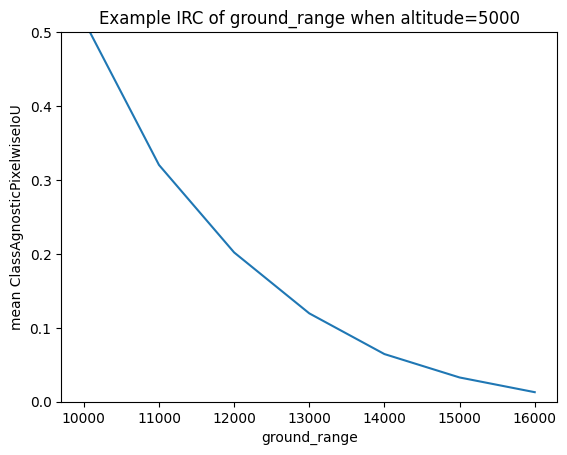

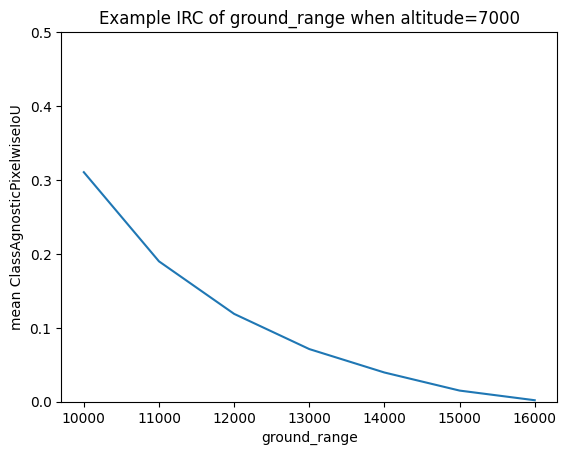

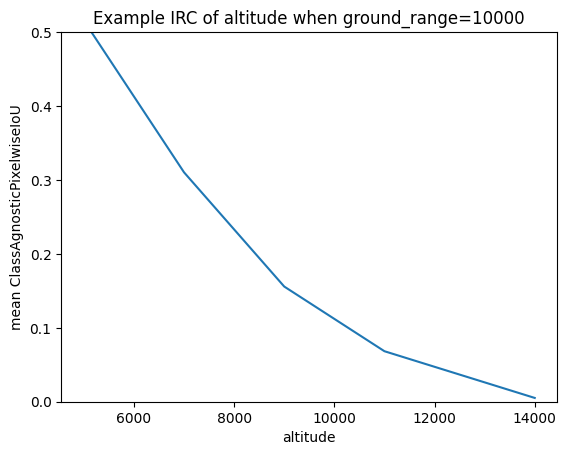

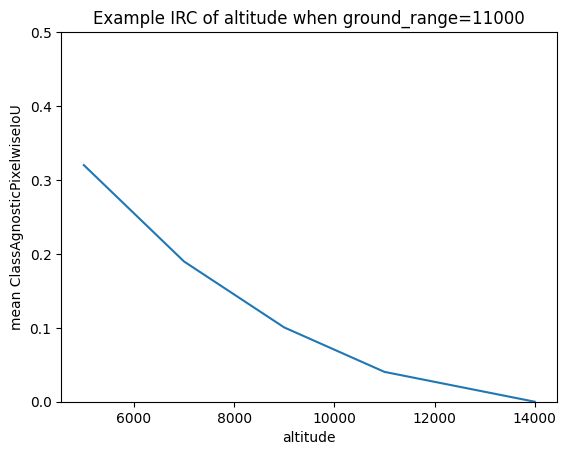

In [8]:
def plotter(x: np.ndarray, y: np.ndarray, xlabel: str, title: str) -> None:
    """Plot item response curve."""
    plt.cla()
    plt.plot(x, y)
    plt.ylim([0, 0.5])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("mean ClassAgnosticPixelwiseIoU")
    plt.show()


x, y = list(), list()
for params, score in curve:
    if params["altitude"] == 5000:
        x.append(params["ground_range"])
        y.append(score)

plotter(np.asarray(x), np.asarray(y), xlabel="ground_range", title="Example IRC of ground_range when altitude=5000")

x, y = list(), list()
for params, score in curve:
    if params["altitude"] == 7000:
        x.append(params["ground_range"])
        y.append(score)

plotter(np.asarray(x), np.asarray(y), xlabel="ground_range", title="Example IRC of ground_range when altitude=7000")

x, y = list(), list()
for params, score in curve:
    if params["ground_range"] == 10000:
        x.append(params["altitude"])
        y.append(score)

plotter(np.asarray(x), np.asarray(y), xlabel="altitude", title="Example IRC of altitude when ground_range=10000")

x, y = list(), list()
for params, score in curve:
    if params["ground_range"] == 11000:
        x.append(params["altitude"])
        y.append(score)

plotter(np.asarray(x), np.asarray(y), xlabel="altitude", title="Example IRC of altitude when ground_range=11000")